See how to use Shor's algorithm to factor 15 here:    <b><a href="https://portal.quantumrings.com/doc/Shors.html">Shor15</a></b>

<i><b>Source code to factorize 15</b></i>

Note: Be sure to use your API token and your account name.

Step 1. Import the required modules and obtain the backend

In [1]:
import os
import numpy as np
import math

import QuantumRingsLib
from QuantumRingsLib import QuantumRegister, ClassicalRegister, QuantumCircuit
from QuantumRingsLib import QuantumRingsProvider
from QuantumRingsLib import job_monitor

from matplotlib import pyplot as plt
from dotenv import load_dotenv

from fractions import Fraction
from math import gcd

In [2]:
load_dotenv() # take environment variables from `.env` file
QUANTUM_RINGS_TOKEN = os.getenv("QUANTUM_RINGS_TOKEN", "")
QUANTUM_RINGS_ACCOUNT_NAME = os.getenv("QUANTUM_RINGS_ACCOUNT_NAME", "")

In [3]:
provider = QuantumRingsProvider(token=QUANTUM_RINGS_TOKEN, name=QUANTUM_RINGS_ACCOUNT_NAME)
backend = provider.get_backend("scarlet_quantum_rings")
print(f"Max Qubits: {provider.active_account()['max_qubits']}")

Max Qubits: 128


Step 2. Define the core methods

In [4]:
def iqft_cct(qc, b, n):
    """
    The inverse QFT circuit
    Args:
        qc (QuantumCircuit):
                The quantum circuit
        b (QuantumRegister):
                The target register
        n (int):
                The number of qubits in the registers to use

    Returns:
        None
    """

    for i in range (n):
        for j in range (1, i+1):
            # for inverse transform, we have to use negative angles
            qc.cu1(-math.pi / 2**(i-j+1), b[j - 1], b[i])
        # the H transform should be done after the rotations
        qc.h(b[i])
    qc.barrier()

def plot_histogram(counts, title=""):
    """
    Plots the histogram of the counts
    Args:
        counts (dict):
            The dictionary containing the counts of states
        titles (str):
            A title for the graph.

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    plt.xlabel("States")
    plt.ylabel("Counts")
    mylist = [key for key, val in counts.items() for _ in range(val)]

    unique, inverse = np.unique(mylist, return_inverse=True)
    bin_counts = np.bincount(inverse)

    plt.bar(unique, bin_counts)

    maxFreq = max(counts.values())
    plt.ylim(ymax=np.ceil(maxFreq / 10) * 10 if maxFreq % 10 else maxFreq + 10)
    # Show plot
    plt.title(title)
    plt.show()
    return

Step 3. Perform the algorithm

In [5]:
shots = 1024
a = 7 # Base
N = 15 # Modulus
source_qubits = math.ceil(math.log2(a)) # Number of qubits for superposition
target_qubits = math.ceil(math.log2(N)) # Number of qubits for computation
total_qubits = source_qubits + target_qubits
print(f"Source Qubits: {source_qubits}")
print(f"Target Qubits: {target_qubits}")
print(f"Total Qubits: {total_qubits}")

Source Qubits: 3
Target Qubits: 4
Total Qubits: 7


In [6]:
# Shor's algorithm to factorize 15 using 7^x mod 15.
q = QuantumRegister(total_qubits, 'q')
c = ClassicalRegister(source_qubits, 'c')
qc = QuantumCircuit(q, c)

# Step 1: Initialization of source qubits in superposition and target qubits in |1>
for i in range(source_qubits):
    qc.h(i)
qc.x(qc.num_qubits - 1)
qc.barrier()

# Step 2: Modular exponentiation (Controlled Multiplication: 7^x mod 15)
qc.cx(q[2],q[4])
qc.cx(q[2],q[5])
qc.cx(q[6],q[4])
qc.ccx(q[1],q[5],q[3])
qc.cx(q[3],q[5])
qc.ccx(q[1],q[4],q[6])
qc.cx(q[6],q[4])
qc.barrier()

# Step 3: Apply Inverse Quantum Fourier Transform (IQFT)
iqft_cct(qc, q, source_qubits)

# Step 4: Measurement of source qubits
for i in range(source_qubits):
    qc.measure(q[i], c[i])

# Draw the circuit
qc.draw('mpl')

       ┌───┐ ╎                                     ╎ ┌───┐               »
q[0]: ■┤ H ├─╎─────────────────────────────────────╎─┤ H ├───────■───────»
       ├───┤ ╎                                     ╎ └───┘┌──────┴──────┐»
q[1]: ■┤ H ├─╎──────────────────■─────────■────────╎──────┤ U1(-pi/2)   ├»
       ├───┤ ╎                  │         │        ╎      └─────────────┘»
q[2]: ■┤ H ├─╎───■────■─────────│─────────│────────╎─────────────────────»
       └───┘ ╎   │    │       ┌─┴─┐       │        ╎                     »
q[3]: ■──────╎───│────│───────┤ X ├──■────│────────╎─────────────────────»
             ╎ ┌─┴─┐  │  ┌───┐└─┬─┘  │    │  ┌───┐ ╎                     »
q[4]: ■──────╎─┤ X ├──│──┤ X ├──│────│────■──┤ X ├─╎─────────────────────»
             ╎ └───┘┌─┴─┐└─┬─┘  │  ┌─┴─┐  │  └─┬─┘ ╎                     »
q[5]: ■──────╎──────┤ X ├──│────■──┤ X ├──│────│───╎─────────────────────»
       ┌───┐ ╎      └───┘  │       └───┘┌─┴─┐  │   ╎                     »
q[6]: ■┤ X ├─╎───────────

The circuit to factor 15 shown above.

In [7]:
# Execute the circuit
job = backend.run(qc, shots=shots)
job_monitor(job)
result = job.result()
counts = result.get_counts()

Job Running
Job Done.
Ending Job Monitor


Counts:  {'000': 239, '010': 260, '100': 245, '110': 280}


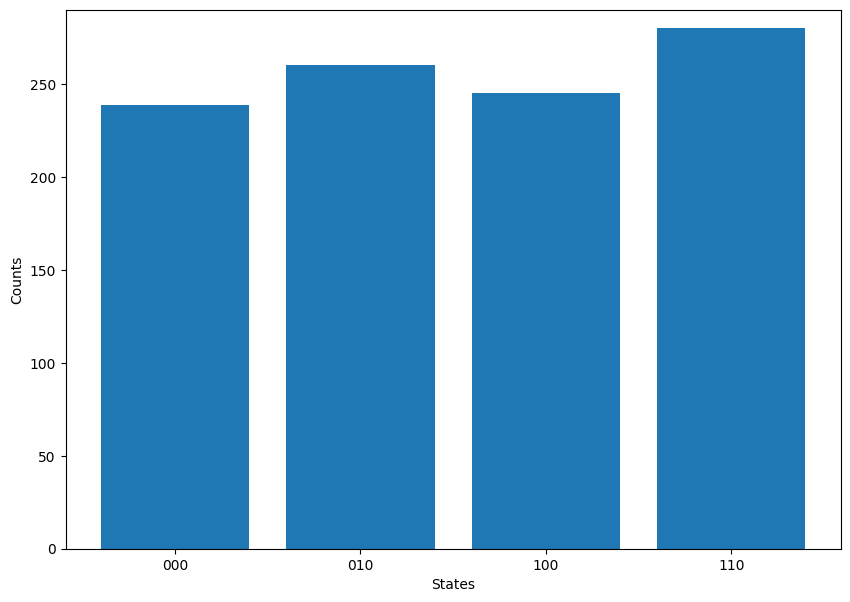

In [8]:
# visualize
print("Counts: ", counts)
plot_histogram(counts)

In [12]:
def period_finding(counts, Q):
    """
    Compute the candidate period r using the measurement outcome histogram.
    This function processes a dictionary of counts where keys are binary strings
    of quantum measurement outcomes. It converts these keys to integer C values,
    computes the best rational approximations of C/Q with denominators not exceeding Q,
    and collects the unique denominators as candidates for r. The function returns
    the smallest candidate r that is strictly greater than 1. If no such candidate
    exists, it returns None.
    Parameters:
        counts (dict): A dictionary where keys are measurement outcomes represented
                       as binary strings.
        Q (int): The denominator used to form the fraction C/Q, typically representing
                 the size of the quantum state space.
    Returns:
        int or None: The smallest candidate period r (greater than 1), or None if no candidate is found.
    """
    C_values = [int(bitstr, 2) for bitstr in counts.keys()]
    fractions = [Fraction(C, Q).limit_denominator(Q) for C in C_values]
    denominators = [frac.denominator for frac in fractions]
    r_candidates = sorted(set(denominators))

    print(f"C_values: {C_values}")
    print(f"fractions: {fractions}")
    print(f"denominators: {denominators}")
    print(f"r_candidates: {r_candidates}")

    for r in r_candidates:
        if r > 1:
            return r
    return None

Q = 2**target_qubits
r = period_finding(counts, Q)
print(f"Fount r: {r}")

C_values: [0, 2, 4, 6]
fractions: [Fraction(0, 1), Fraction(1, 8), Fraction(1, 4), Fraction(3, 8)]
denominators: [1, 8, 4, 8]
r_candidates: [1, 4, 8]
Fount r: 4


$a^r \equiv 1 \pmod N$

$a^{(\frac{r}{2})^2} \equiv 1 \pmod N$

$a^{(\frac{r}{2})^2} - 1 \equiv 0 \pmod N$

$(a^\frac{r}{2} + 1)(a^\frac{r}{2} - 1) \equiv 0 \pmod N$

$Answer = GCD(a^\frac{r}{2} + 1, N), GCD(a^\frac{r}{2} - 1, N)$

In [13]:
# Compute factors
factor1 = math.gcd(a**(r//2) + 1, N)
factor2 = math.gcd(a**(r//2) - 1, N)
print(f"Factors: {factor1}, {factor2}")

Factors: 5, 3


A plot of the execution results is shown above. Compare this with the calculated values.

Footnotes

[1] This section is based on [10], [14], and [16].

[2] https://research.ibm.com/blog/factor-15-shors-algorithm

[3] https://en.wikipedia.org/wiki/Integer_factorization_records#Records_for_efforts_by_quantum_computers